## SAGA Paper 4, FIGURE 6: NUV SFR MS and sSFR
             

In [1]:
import numpy as np
from myplotstyle import plt,get_figsize

%matplotlib inline

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import kurtosis, skew

import matplotlib
import matplotlib.lines as mlines
import matplotlib.backends.backend_pdf

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

In [2]:
saga = SAGA.QuickStart()

SAGA `shared_dir` set to /Users/mg37/DropBox/SAGA/
SAGA `local_dir`  set to /Users/mg37/Projects/SAGA/


In [3]:
# GET ALL GALAXIES
base   = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

sats = C.is_sat.filter(base)

## FIT A LINE

In [4]:
def a_line(x,*p) :
    return p[0]+p[1]*x


def fit_a_line(x,y,err,name):
    p0 = [1,-9]
    p, pcov = curve_fit(a_line, x, y, sigma=err,p0=p0)

    
    perr = np.sqrt(np.diag(pcov))
    
    xf = np.arange(-5,11,0.25)
    yf = a_line(xf,*p)
    
    rms = np.mean(np.abs(y -(p[0]+p[1]*x)))
    sk = skew(y -(p[0]+p[1]*x))
    print('{}:  m, b, rms, sk:  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}'.format(name,p[1],p[0],rms,sk))
    
    
    return xf,yf, p[1],p[0], rms,sk

# DIFFERENT SAMPLES

In [5]:
ssfr_nuv = sats['nuv_sfr']    - sats['log_sm']
ssfr_ha  = sats['Halpha_sfr'] - sats['log_sm']

mnuv     = (sats['quenched'] ==0) & ((ssfr_nuv-0.2) > -11) & (sats['nuv_sfr_err'] < 0.5)#& (sats['nuv_mag_flag'] ==1)
mha      = (sats['quenched'] ==0) & ((ssfr_ha-0.2) > -11) & (sats['Halpha_sfr_err'] < 0.5)

print('NUV galaxies: ',np.sum(mnuv))
print('Halpha galaxies: ',np.sum(mha))

mup  = sats['nuv_mag_flag'] ==0

NUV galaxies:  263
Halpha galaxies:  265


In [6]:
# FIT LINES:  Halpha, NUV

mline = (sats['log_sm'] > 6.75)

nx,ny,n_m,n_b,nrms,nsk = fit_a_line(sats['log_sm'][mline&mnuv],sats['nuv_sfr'][mline&mnuv], \
                               sats['nuv_sfr_err'][mline&mnuv],'NUV')
hax,hay,ha_m,ha_b,harms,hsk = fit_a_line(sats['log_sm'][mline&mha],sats['Halpha_sfr'][mline&mha], \
                               sats['Halpha_sfr_err'][mline&mha],'Ha ')


NUV:  m, b, rms, sk:  0.79  -8.30  0.29  0.11
Ha :  m, b, rms, sk:  0.89  -9.15  0.40  0.85


In [7]:
# FIT LINES:  Halpha / NUV

eta    = sats['Halpha_sfr'] - sats['nuv_sfr']
eta_err = np.sqrt(sats['nuv_sfr_err']**2 + sats['Halpha_sfr_err']**2)


exf,eyf,e_m,e_b,erms,esk = fit_a_line(sats['log_sm'][mnuv&mha&~mup],eta[mnuv&mha&~mup],eta_err[mnuv&mha&~mup],'Eta')
exf,eyf,e_m,e_b,erms,esk = fit_a_line(sats['log_sm'][mnuv&mha],eta[mnuv&mha],eta_err[mnuv&mha],'Eta')


Eta:  m, b, rms, sk:  0.06  -0.46  0.36  0.37
Eta:  m, b, rms, sk:  0.05  -0.39  0.36  0.33


In [8]:
pbins = np.linspace(0, 100, 8)
log_sm = np.concatenate([sats['log_sm']])
log_sm = log_sm[log_sm >= 6.75]
bins = np.percentile(log_sm, pbins)
x = np.percentile(log_sm, (pbins[1:]+pbins[:-1])*0.5)

In [9]:
def bin_wmean(bins,x,y,yerr):
    
    wmean,werr1, werr2 = [],[],[]
    
    for i,b in enumerate(bins[:-1]):
        m = (x>bins[i]) & (x<bins[i+1])

        xx = np.percentile(y[m], [16, 50, 84]) 
        
        wmean.append(xx[1])
        werr1.append(xx[1] - xx[0])
        werr2.append(xx[2] - xx[1])
        
    return wmean,werr1,werr2
def plot_sfs(sats_sm, sats_sfr, sats_sfr_err, label, color, ax):
    
    s=8
    ss = 4
    
    blabel = label+" binned"
    slabel = label+' satellites'
    if label == 'Ha':
        blabel = r'${\rm H}\alpha$ binned'
        slabel = r'${\rm H}\alpha$ satellites'
    
    ax.plot(sats_sm, sats_sfr,'o',c='grey',ms=ss,alpha=0.7,label=slabel)

    
    ax.errorbar(sats_sm, sats_sfr,yerr = sats_sfr_err,\
                alpha=0.3,fmt='none',color='grey')

    a,b,c = bin_wmean(bins,sats_sm,sats_sfr,sats_sfr_err)       
        
    ax.plot(x,a,'s',c=color,ms=8,label=blabel)
    ax.errorbar(x,a,yerr=[b,c],ls='none',c=color,ms=8,alpha=0.7,lw=4)
    ax.plot(x,a,'s',c='k',ms=9,alpha=0.7,mfc='none')
  
    for xx,aa,bb,cc in zip(x,a,b,c):
        print('{:0.1f}\t  {:0.2f}\t  {:0.2f}\t  {:0.2f}'.format(xx,aa,bb,cc))
        
    handles, labels = ax.get_legend_handles_labels()
    order = [1,0]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
              handletextpad=0.1,loc='upper left')

    
    return ax


NUV
6.9	  -2.84	  0.22	  0.30
7.3	  -2.47	  0.41	  0.23
7.6	  -2.40	  0.30	  0.37
7.8	  -2.19	  0.42	  0.40
8.2	  -1.94	  0.35	  0.37
8.6	  -1.65	  0.25	  0.41
9.4	  -0.88	  0.37	  0.44
Halpha
6.9	  -3.00	  0.34	  0.40
7.3	  -2.61	  0.49	  0.60
7.6	  -2.57	  0.31	  0.99
7.8	  -2.20	  0.44	  0.44
8.2	  -2.11	  0.33	  0.79
8.6	  -1.53	  0.44	  0.64
9.4	  -0.75	  0.44	  0.39
ETA
6.9	  -0.07	  0.36	  0.38
7.3	  -0.05	  0.36	  0.47
7.6	  -0.03	  0.33	  0.63
7.8	  0.03	  0.40	  0.44
8.2	  -0.01	  0.36	  0.38
8.6	  0.07	  0.41	  0.38
9.4	  0.17	  0.58	  0.58


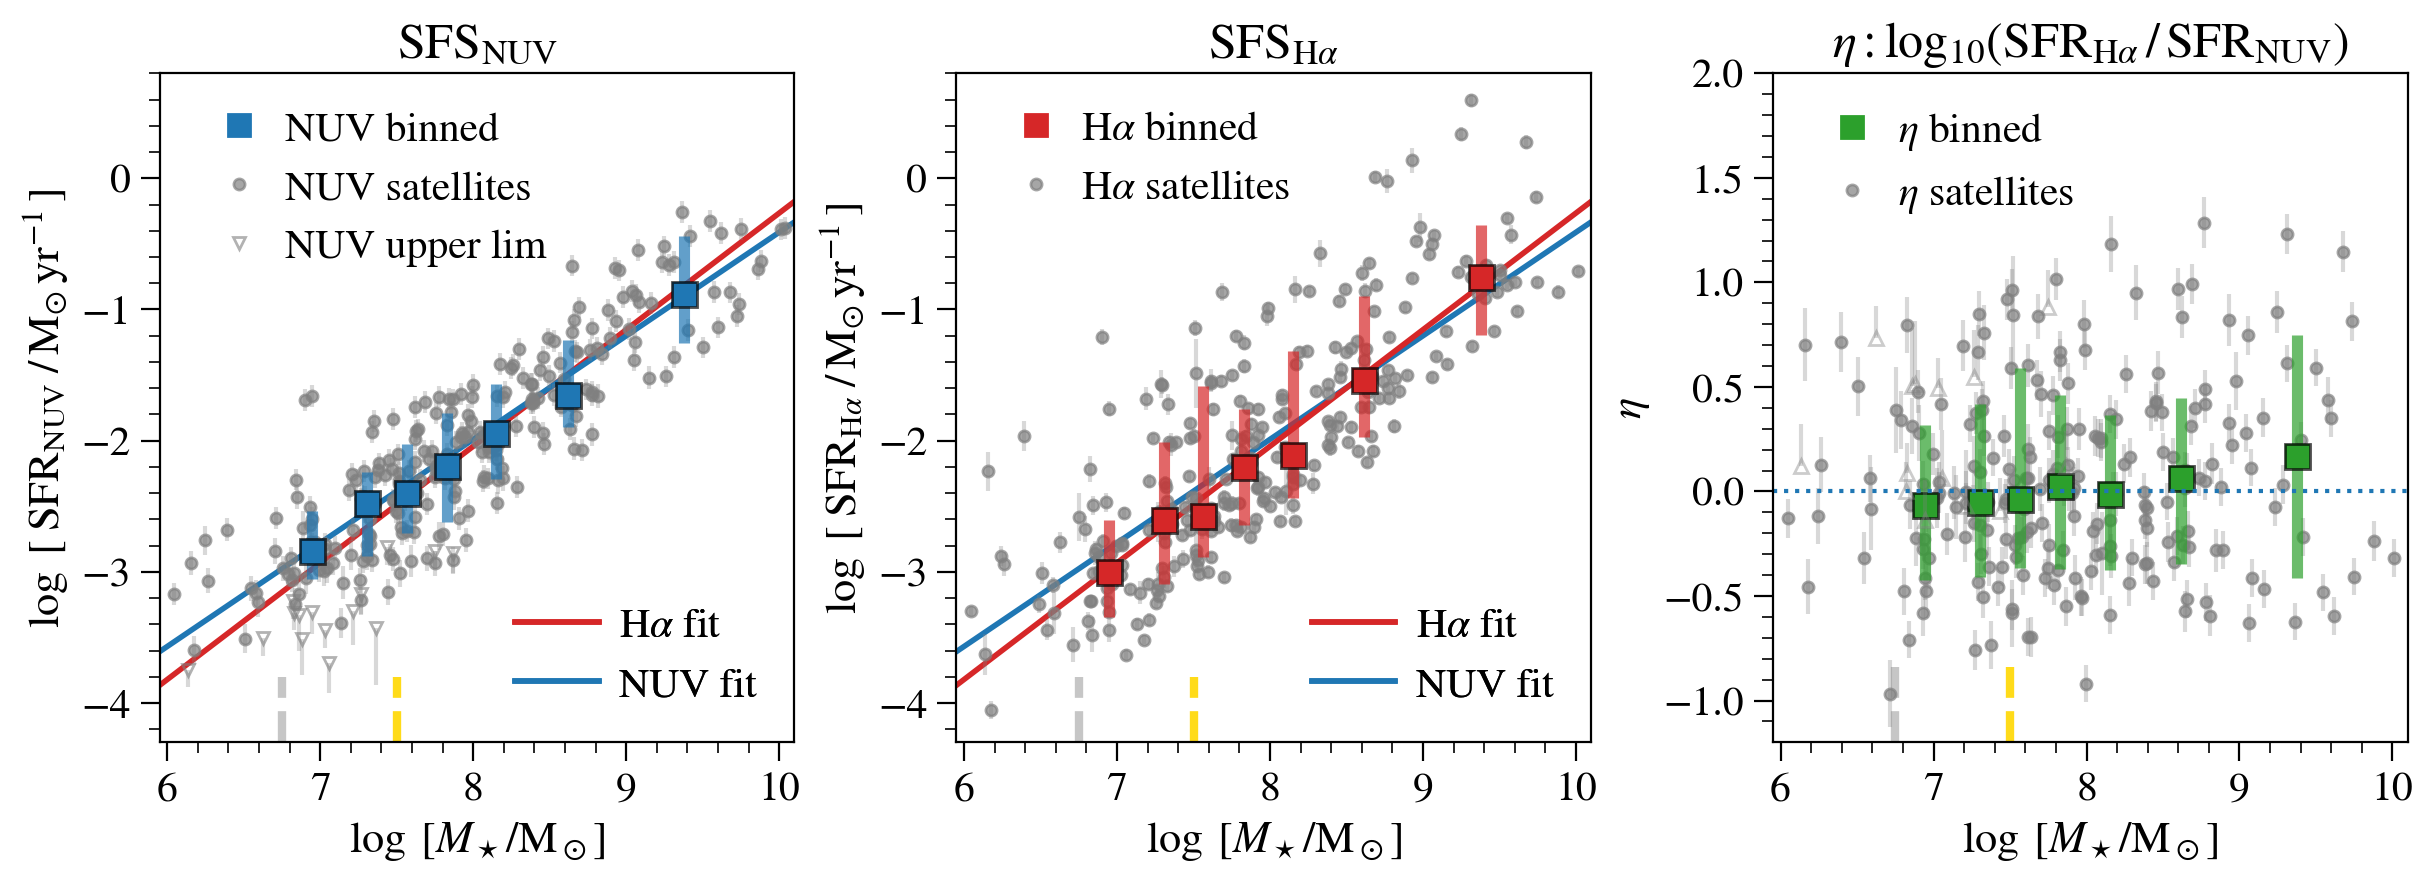

In [10]:
pdf = matplotlib.backends.backend_pdf.PdfPages('figure_SFSM_internal.pdf')
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=get_figsize(wide=True, ratio=2.9))

#################

print('NUV')

ax1 = plot_sfs(sats['log_sm'][mnuv&~mup],sats['nuv_sfr'][mnuv&~mup],sats['nuv_sfr_err'][mnuv&~mup],\
                                'NUV', 'C0', ax1)


# ERRORS ON UPPER LIMITS
yerr_upp = np.zeros(np.sum(mnuv&mup))
ax1.plot(sats['log_sm'][mup&mnuv],sats['nuv_sfr'][mup&mnuv],'v',c='grey',alpha=0.6,ms=4,mfc='none',\
              label = 'NUV upper lim')
ax1.errorbar(sats['log_sm'][mnuv&mup],sats['nuv_sfr'][mnuv&mup],\
             yerr = [sats['nuv_sfr_err'][mnuv&mup],yerr_upp],alpha=0.3,\
             fmt='none',color='grey')
handles, labels = ax1.get_legend_handles_labels()
order = [1,0,2]

l1 = ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
              handletextpad=0.1,loc='upper left')

ax1.add_artist(l1)

##################

print('Halpha')
plot_sfs(sats['log_sm'][mha],sats['Halpha_sfr'][mha], sats['Halpha_sfr_err'][mha],\
                        'Ha', 'C3', ax2)

handles, labels = ax2.get_legend_handles_labels()
order = [1,0]

l2 = ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
              handletextpad=0.1,loc='upper left')
ax2.add_artist(l2)

######
ax1.set_ylim(-4.3,0.8)
ax2.set_ylim(-4.3,0.8)

ax1.plot([7.5,7.5],[-4.3,-3.8],ls='--',c='gold',alpha=0.9,zorder=0,lw=3)
ax1.plot([6.75,6.75],[-4.3,-3.8],ls='--',c='silver',alpha=0.9,zorder=0,lw=3)
ax2.plot([7.5,7.5],[-4.3,-3.8],ls='--',c='gold',alpha=0.9,zorder=0,lw=3)
ax2.plot([6.75,6.75],[-4.3,-3.8],ls='--',c='silver',alpha=0.9,zorder=0,lw=3)
ax3.plot([7.5,7.5],[-1.2,-0.8],ls='--',c='gold',alpha=0.9,zorder=0,lw=3)
ax3.plot([6.75,6.75],[-1.2,-0.8],ls='--',c='silver',alpha=0.9,zorder=0,lw=3)


############################

print('ETA')

plot_sfs(sats['log_sm'][mnuv&mha&~mup],eta[mnuv&mha&~mup], eta_err[mnuv&mha&~mup],\
                        '$\eta$', 'C2', ax3)


eta_up = np.zeros(np.sum(mnuv&mha&mup))
ax3.plot(sats['log_sm'][mnuv&mha&mup],eta[mnuv&mha&mup],'^',c='grey',alpha=0.4,mfc='none')
ax3.errorbar(sats['log_sm'][mnuv&mha&mup],eta[mnuv&mha&mup],\
             [eta_up,eta_err[mnuv&mha&mup]],alpha=0.3,fmt='none',ms=4,color='grey')

ez = ax3.axhline(0,linestyle='dotted')
ax3.set_ylim(-1.2,2)


ax3.set_ylabel(r"$\eta$")
ax3.set_title(r"$\eta: \log_{10}({\rm SFR}_{{\rm H}\alpha}\, /\, {\rm SFR}_{\rm NUV})$")

ax1.set_xlim(5.95,10.1)
ax2.set_xlim(5.95,10.1)
ax3.set_xlim(5.95,10.1)

ax1.set_title(r'SFS$_{\rm NUV}$')
ax2.set_title(r"SFS$_{{\rm H}\alpha}$")

ax1.set_ylabel(r'$\log~[\;{\rm SFR}_{\rm NUV} \; / \, {\rm M}_{\odot}\,{\rm yr}^{-1}\,]$')
ax2.set_ylabel(r'$\log~[\;{\rm SFR}_{{\rm H}\alpha} \; / \, {\rm M}_{\odot}\,{\rm yr}^{-1}\,]$')


ax1.set_xlabel(r'$\log\;[M_\star/{\rm M}_\odot]$')
ax2.set_xlabel(r'$\log\;[M_\star/{\rm M}_\odot]$')
ax3.set_xlabel(r'$\log\;[M_\star/{\rm M}_\odot]$')



hf, = ax1.plot(hax,hay,'C3',zorder=1,lw=2,label=r'${\rm H}\alpha$ fit')
nf, = ax1.plot(nx,ny,'C0',lw=2,label='NUV fit',zorder=1)

l3 = ax1.legend(handles=[hf,nf],loc='lower right')
ax1.add_artist(l3)

nf, = ax2.plot(nx,ny,'C0',lw=2,zorder=1,label='NUV fit')
hf, = ax2.plot(hax,hay,'C3',lw=2,label=r'${\rm H}\alpha$ fit',zorder=1)

l4 = ax2.legend(handles=[hf,nf],loc='lower right')
ax2.add_artist(l4)

pdf.savefig()
pdf.close()